In [217]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [218]:
df = pd.read_csv('gamesExt.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns

Index(['towerKillsDiff', 'inhibitorKillsDiff', 'baronKillsDiff',
       'dragonKillsDiff', 'riftHeraldDiff', 'gameId', 'creationTime',
       'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower',
       'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
       't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1',
       't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2',
       't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4',
       't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_cha

In [219]:
df = df[0:200]

In [220]:
df.head()

,towerKillsDiff,inhibitorKillsDiff,baronKillsDiff,dragonKillsDiff,riftHeraldDiff,gameId,creationTime,gameDuration,seasonId,winner,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,6,1,2,2,-1,3326086514,1504279457970,1949,9,1,...,5,0,0,1,1,114,67,43,16,51
1,8,4,0,2,1,3229566029,1497848803862,1851,9,1,...,2,0,0,0,0,11,67,238,51,420
2,6,1,1,0,0,3327363504,1504360103310,1493,9,1,...,2,0,0,1,0,157,238,121,57,28
3,9,2,1,2,0,3326856598,1504348503996,1758,9,1,...,0,0,0,0,0,164,18,141,40,51
4,6,2,1,2,0,3330080762,1504554410899,2094,9,1,...,3,0,0,1,0,86,11,201,122,18


In [221]:
def compara(atributo1, atributo2, pr=0):
    soma = (atributo1 == atributo2).sum()
    somaVazio = (atributo2 == 0).sum()
    n = atributo1.size
    porcentagem = round(soma*100/n,2)
    porcentagemVazio = round(somaVazio*100/n,2)
    if(pr):
        print("Em {}% das partidas as equipes '{}' também conseguem '{}'. {}% das partidas não ocorre '{}'"
              .format(porcentagem, atributo1.name, atributo2.name, porcentagemVazio, atributo2.name))
    return porcentagem

In [222]:
def perm_first(atributo1, atributo2, it=500):
    
    lista = []
    taxaObs = compara(atributo1, atributo2, 1)
    srt1 = atributo1.name
    str2 = atributo2.name
    atributo1 = atributo1.copy()
    
    for i in range(it):
        atributo1 = np.random.permutation(atributo1)
        lista.append(compara(atributo1, atributo2, 0))

    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    plt.title("Partidas com equipes {} e {}".format(srt1, str2))
    plt.axvline(x=taxaObs,c='red')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

In [223]:
def novo_atr_diff(df, str1, str2, novaStr, index, winflag, winVal):
    df.insert(index, novaStr, df[str1] - df[str2])
    for index, value in df[winflag].items():
        if value == winVal:
            df[novaStr][index] = -df[novaStr][index]

In [224]:
def diff(df, atributo1, atributo2, winflag):
    winTeam = df.groupby([winflag]).mean()[[atributo1, atributo2]]
    diff = abs(winTeam[atributo1] - winTeam[atributo2]).mean()
    return diff

In [225]:
def perm_diff(df, atributo1, atributo2, winflag, it=200):
    df = df.copy()
    lista = []
    taxaObs = diff(df, atributo1, atributo2, winflag)
    print("taxa obs: {}".format(taxaObs))

    for i in range(it):
        if i % 20 == 0: print("iteracoes: {}/{}".format(i, it))
        winArray = np.random.permutation(df[winflag])
        df[winflag] = pd.Series(winArray)
        lista.append(diff(df, atributo1, atributo2, winflag))
        
    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    #plt.title()
    #plt.axvline(x=taxaObs,c='red')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

taxa obs: 0.48913043478260865
iteracoes: 0/200
iteracoes: 20/200
iteracoes: 40/200
iteracoes: 60/200
iteracoes: 80/200
iteracoes: 100/200
iteracoes: 120/200
iteracoes: 140/200
iteracoes: 160/200
iteracoes: 180/200


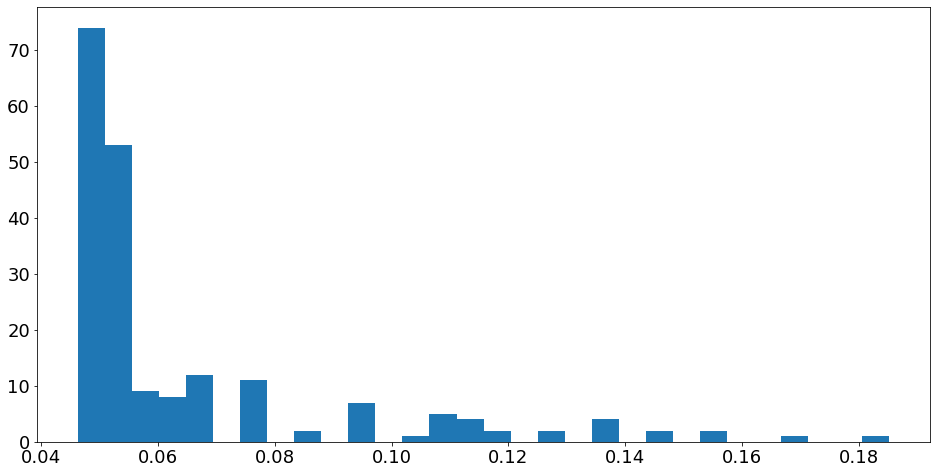

In [226]:
perm_diff(df, 't1_baronKills', 't2_baronKills', 'winner')

taxa obs: 6.0688405797101455
iteracoes: 0/200
iteracoes: 20/200
iteracoes: 40/200
iteracoes: 60/200
iteracoes: 80/200
iteracoes: 100/200
iteracoes: 120/200
iteracoes: 140/200
iteracoes: 160/200
iteracoes: 180/200


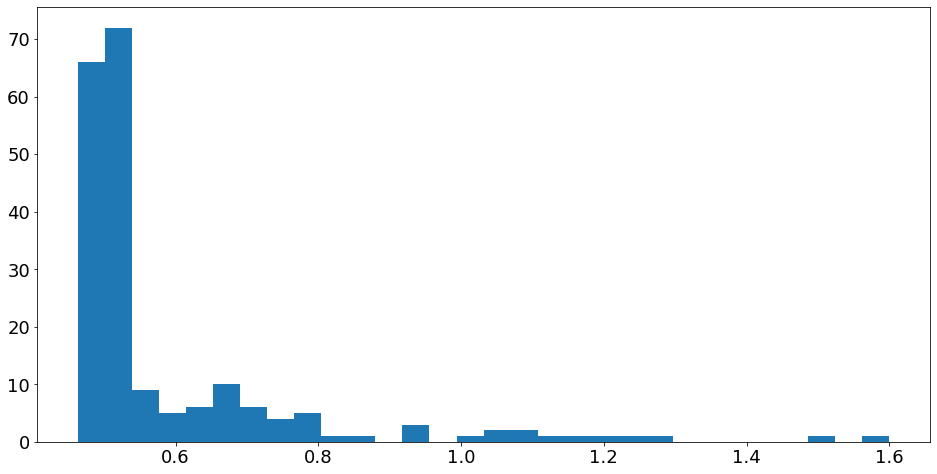

In [227]:
perm_diff(df, 't1_towerKills', 't2_towerKills', 'winner')

Em 53.5% das partidas as equipes 'winner' também conseguem 'firstBlood'. 0.5% das partidas não ocorre 'firstBlood'
Em 70.0% das partidas as equipes 'winner' também conseguem 'firstTower'. 2.0% das partidas não ocorre 'firstTower'
Em 83.0% das partidas as equipes 'winner' também conseguem 'firstInhibitor'. 11.5% das partidas não ocorre 'firstInhibitor'


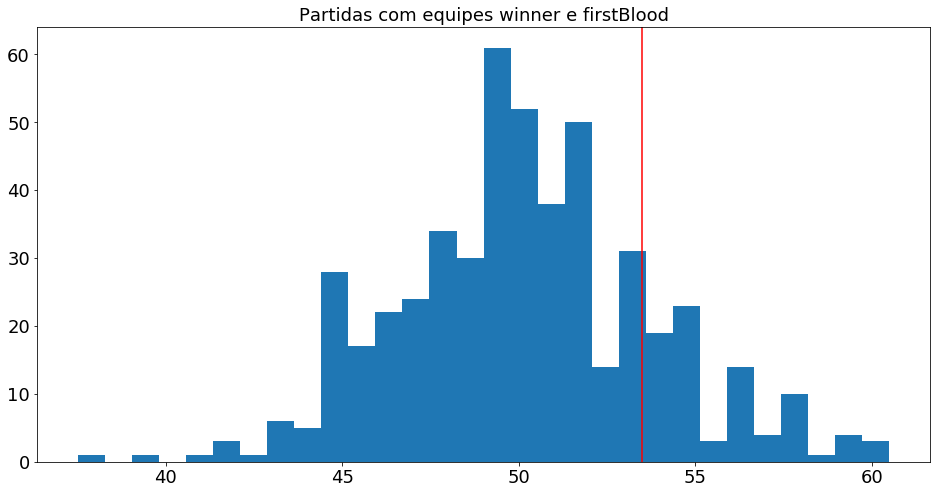

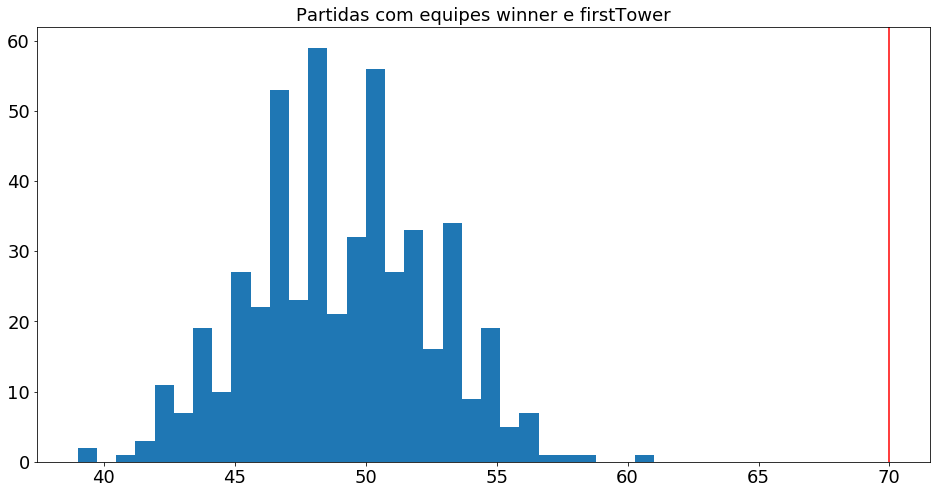

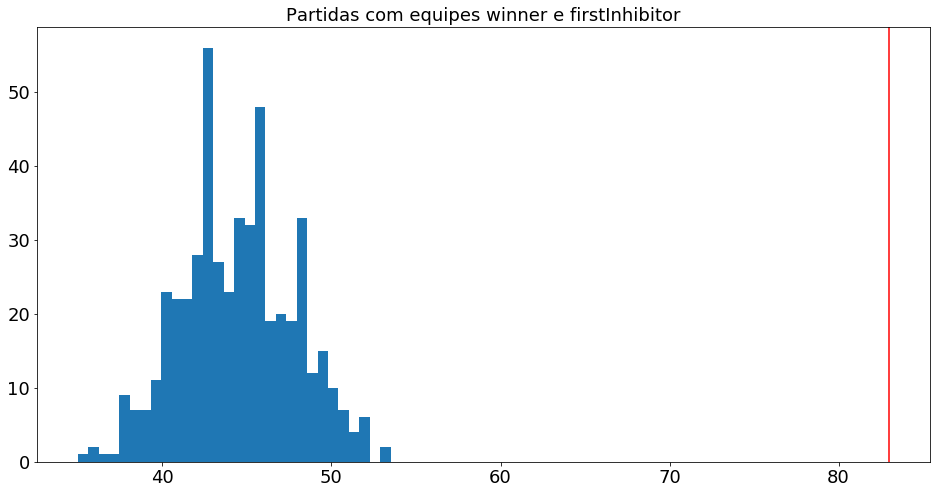

In [228]:
perm_first(df['winner'], df['firstBlood'])
perm_first(df['winner'], df['firstTower'])
perm_first(df['winner'], df['firstInhibitor'])